<a href="https://colab.research.google.com/github/karank85/speech-recognition/blob/main/Copy_of_Project_2_Non_DL_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd
import random

import librosa

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from tqdm import tqdm


import glob
import torch

from pathlib import Path

In [2]:
librosa.__version__

'0.10.1'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Assumptions:
# - The transcription file is located in the same directory as the audio files.
class AudioDataset:
  """
  Class for loading and storing audio data.
  """

  def __init__(self):
    self.df = pd.DataFrame(columns=['id', 'path', 'transcription'])

  def load_transcriptions(self, directory_path: str) -> bool:
    """
    Load all transcriptions from a given directory, including subdirectories.
    Returns False if no transcription files were found, or if any failed to load.
    """
    sound_names = glob.glob(
        f"{directory_path}/**/*.wav",
        recursive=True
    )

    if len(sound_names) == 0:
      return False

    for path in sound_names:
      if not self.load_transcription_file(path):
        return False

    return True



  def load_transcription_file(self, file_path: str) -> bool:
    """
    Parse transcription file and records the audio ID - subtitle mapping.
    Returns False if the file could not be read.
    """

    file_directory = Path(file_path).parent
    file_name = Path(file_path).stem
    self.df.loc[len(self.df)] = {
        'id':file_name,
        'transcription':file_directory.name,
        'path': f'{file_directory}/{file_name}.wav'
    }
    return True

  def keys(self):
    return iter(self.df['id'])

  def get(self, id: int):
    """
    Retrieve a dataframe row from ID.
    """
    return self.df.loc[self.df['id'] == id]

In [6]:
random.seed(42)

def split_dataframe(df, ratio):
    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the split index
    split_index = int(len(df_shuffled) * ratio)

    # Split the DataFrame
    df_1 = df_shuffled.iloc[:split_index]
    #df_2 = df_shuffled.iloc[split_index:] unneeded for training

    return df_1

In [7]:
df_dict = {}

In [8]:
all_subdirectories = glob.glob(
        f"/content/drive/MyDrive/test_hmm/*/",
        recursive=True
)

for path in all_subdirectories:
  fruit_label = Path(path).name
  ds = AudioDataset()
  if ds.load_transcriptions(path):
    df_dict[fruit_label] = split_dataframe(ds.df, 0.8)

In [9]:
df_dict

{'apple':          id                                               path transcription
 0   apple10  /content/drive/MyDrive/test_hmm/apple/apple10.wav         apple
 1   apple12  /content/drive/MyDrive/test_hmm/apple/apple12.wav         apple
 2   apple01  /content/drive/MyDrive/test_hmm/apple/apple01.wav         apple
 3   apple14  /content/drive/MyDrive/test_hmm/apple/apple14.wav         apple
 4   apple06  /content/drive/MyDrive/test_hmm/apple/apple06.wav         apple
 5   apple09  /content/drive/MyDrive/test_hmm/apple/apple09.wav         apple
 6   apple03  /content/drive/MyDrive/test_hmm/apple/apple03.wav         apple
 7   apple02  /content/drive/MyDrive/test_hmm/apple/apple02.wav         apple
 8   apple15  /content/drive/MyDrive/test_hmm/apple/apple15.wav         apple
 9   apple05  /content/drive/MyDrive/test_hmm/apple/apple05.wav         apple
 10  apple08  /content/drive/MyDrive/test_hmm/apple/apple08.wav         apple
 11  apple11  /content/drive/MyDrive/test_hmm/apple/app

In [10]:
sample_df = df_dict['apple']
sample_input_file = sample_df['path'].iloc[0]
print("Selected input file: ", sample_input_file)

Selected input file:  /content/drive/MyDrive/test_hmm/apple/apple10.wav


<Axes: title={'center': 'Audio signal'}, xlabel='Time', ylabel='Amplitude'>

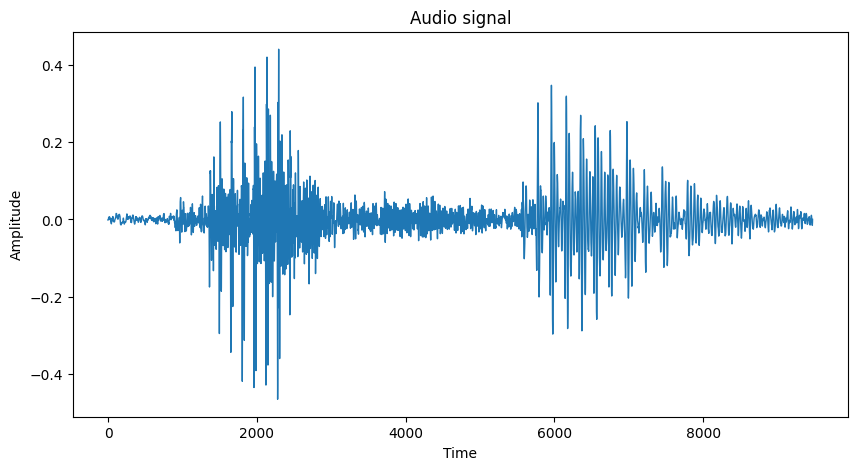

In [11]:
audio, sampling_freq = librosa.load(sample_input_file)
pd.Series(audio).plot(figsize=(10, 5),lw=1, title="Audio signal", xlabel="Time", ylabel="Amplitude")

Text(0.5, 1.0, 'Power Spectrum')

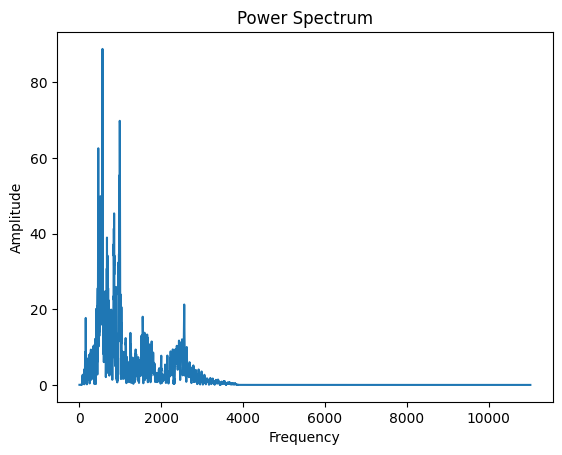

In [12]:
fft = np.fft.fft(audio)

magnitude = np.abs(fft)
frequency = np.linspace(0, sampling_freq, len(magnitude))

left_freq = frequency[:int(len(frequency)/2)]
left_mag = magnitude[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Power Spectrum")

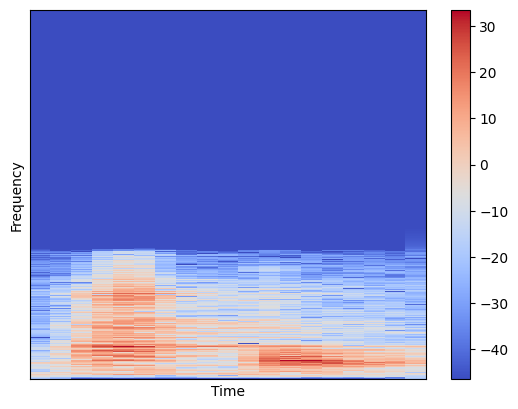

In [13]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sampling_freq, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


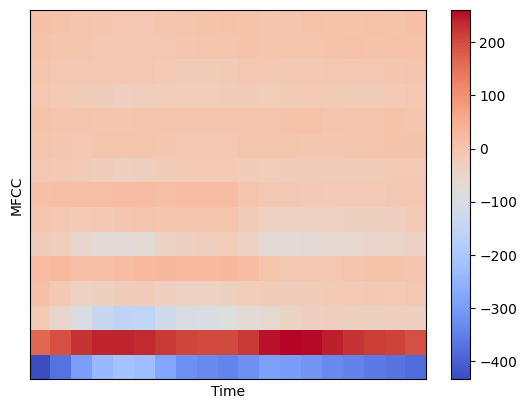

In [14]:
mfccs = librosa.feature.mfcc(y=audio, n_fft=n_fft, hop_length=hop_length, n_mfcc=15)
librosa.display.specshow(mfccs, sr=sampling_freq, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Extracting Features

In [15]:
# from librosa.feature import mfcc
# import librosa
# audio, sampling_freq = librosa.load(ds.df.head()['path'].values[0])
# mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
# print('\nNumber of windows =', mfcc_features.shape[0])
# print('Length of each feature =', mfcc_features.shape[1])

In [16]:
# mfcc_features = mfcc_features.T
# plt.matshow(mfcc_features)
# plt.title('MFCC')

In [17]:
!pip install hmmlearn
!pip install features

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.6 MB/s eta 0:00:00


In [18]:
import os
import numpy as np
from scipy.io import wavfile
from hmmlearn import hmm #importing GaussianHMM
import librosa # reading wavefilesfrom librosa.feature import mfcc #to extract mfcc features

In [19]:
class HMMTrainer(object):
  def __init__(self, model_name='GaussianHMM', n_components=4):
     self.model_name = model_name
     self.n_components = n_components

     self.models = []
     if self.model_name == 'GaussianHMM':
        self.model=hmm.GaussianHMM(n_components=4)
     else:
        print("Please choose GaussianHMM")

  def train(self, X):
      self.models.append(self.model.fit(X))

  def get_score(self, input_data):
      return self.model.score(input_data)

In [20]:
hmm_models = []

for df in df_dict.items():
  fruit_label = df[0]
  X = np.array([])
  for index, row in df[1].iloc[:-1,:].iterrows():
    # Read the input file
    audio, sampling_freq = librosa.load(row['path'])
    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
    # Append to the variable X
    if len(X) == 0:
      X = mfcc_features[:, :15]  # 15 here denotes the number of MFCC coefficients to consider
    else:
      X = np.append(X, mfcc_features[:, :15], axis=0)
    # Append the label
    # print('X.shape =', X.shape)

  # Train HMM model for this iteration
  hmm_trainer = HMMTrainer()
  hmm_trainer.train(X)  # Train using the current MFCC features
  hmm_models.append((hmm_trainer, fruit_label))


In [21]:
print(len(hmm_models))

7


In [22]:
test_files = {}

for df in df_dict.items():
  truth_label = df[0]
  selected_test = df[1].iloc[-1,:]
  test_files[truth_label] = selected_test['path']

In [23]:
print(test_files)

{'apple': '/content/drive/MyDrive/test_hmm/apple/apple11.wav', 'banana': '/content/drive/MyDrive/test_hmm/banana/banana11.wav', 'lime': '/content/drive/MyDrive/test_hmm/lime/lime13.wav', 'orange': '/content/drive/MyDrive/test_hmm/orange/orange03.wav', 'kiwi': '/content/drive/MyDrive/test_hmm/kiwi/kiwi05.wav', 'pineapple': '/content/drive/MyDrive/test_hmm/pineapple/pineapple12.wav', 'peach': '/content/drive/MyDrive/test_hmm/peach/peach05.wav'}


In [24]:
for truth_label, path in test_files.items():
  audio, sampling_freq = librosa.load(path)
  # Extract MFCC features
  mfcc_features = librosa.feature.mfcc(sr=sampling_freq, y=audio)
  X = mfcc_features[:, :15]
  scores = []
  for hmm_model, label in hmm_models:
    score = hmm_model.get_score(X)
    scores.append(score)
  index = np.array(scores).argmax()
  # Print the output
  print("\nTrue:", truth_label)
  print("Predicted:", hmm_models[index][1])


True: apple
Predicted: apple

True: banana
Predicted: banana

True: lime
Predicted: lime

True: orange
Predicted: orange

True: kiwi
Predicted: kiwi

True: pineapple
Predicted: pineapple

True: peach
Predicted: peach


In [25]:
!pip install torchaudio ipywebrtc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/731.7 MB 1.7 MB/s eta 0:05:27
ERROR: Operation cancelled by user


In [26]:
# Download a static FFmpeg build and add it to PATH.
exist = !which ffmpeg
if not exist:
  !curl https://johnvansickle.com/ffmpeg/releases/ffmpeg-release-amd64-static.tar.xz -o ffmpeg.tar.xz \
     && tar -xf ffmpeg.tar.xz && rm ffmpeg.tar.xz
  ffmdir = !find . -iname ffmpeg-*-static
  path = %env PATH
  path = path + ':' + ffmdir[0]
  %env PATH $path
print('')
!which ffmpeg
print('Done!')


/usr/bin/ffmpeg
Done!


In [27]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio

from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'ipywebrtc'

In [ ]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

In [ ]:
# Write to recording.webm
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)

# Translate recording.wemb to file.wav
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic

# Extract features from input and predict
input_audio, sr = librosa.load('file.wav')
mfcc_features = librosa.feature.mfcc(sr=sr, y=input_audio)
X = mfcc_features[:, :15]
scores = []
for hmm_model, label in hmm_models:
  score = hmm_model.get_score(X)
  scores.append(score)
index = np.array(scores).argmax()
print("Predicted:", hmm_models[index][1])

# Saving the model


In [28]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

In [30]:
def save_object(obj, filename):
    """
    Serialize object and store it in the newly
    created file with the specified file name.

    Note: This works for array as well.
    """

    with open(f"{filename}.pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
  """
  Load serialized object and return it. Exception will
  be raised if the specified file is missing.
  """

  with open(f"{filename}.pkl", 'rb') as inp:
    return pickle.load(inp)
  print(f"File '{filename}.pkl' not found.")

# ==== Usage Example ====
#
# Save object:
# foo = Foo()
# save_object(foo, 'foo')
#
# Load object:
# foo_obj = load_object('foo')